## FK Homogeneous Transfomation Matrix

In [6]:
#%matplotlib notebook
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, pinv, norm

### Plot function:

In [7]:
def Plot(X, Y):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    n = len(X)
    ax.axis([-1,n,-1,n])
    ax.grid()
    ax.plot(X, Y)
    ax.scatter(X, Y)
    ax.text(X[0], Y[0]-0.4, 'Base', ha='center')
    ax.text(X[-1], Y[-1]+0.2, 'End Effector', ha='left')
    ax.plot(Target[0], Target[1], marker='x', ms=20, color='red')
    ax.text(Target[0], Target[1]-0.2, 'Target', ha='left', va='top', color='red')

### 3-Link FK: 3x3 Homogeneous Transformation Matrix

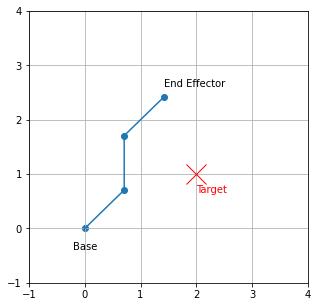

In [8]:
Target = np.array([2, 1, 1], dtype='float64') # dummy target

L0 = 0
L1 = 1
L2 = 1
L3 = 1
th0 = np.radians(45)
th1 = np.radians(45)
th2 = np.radians(-45)

R0 = np.array([[np.cos(th0), -np.sin(th0), L0],
               [np.sin(th0),  np.cos(th0),  0],
               [         0,             0,  1]])


R1 = np.array([[np.cos(th1), -np.sin(th1), L1],
               [np.sin(th1),  np.cos(th1),  0],
               [         0,             0,  1]])


R2 = np.array([[np.cos(th2), -np.sin(th2), L2],
               [np.sin(th2),  np.cos(th2),  0],
               [         0,             0,  1]])

R3 = np.array([[1, 0, L3],
               [0, 1,  0],
               [0, 0,  1]])

# R3 = np.array([[L3],
#                 [0],
#                 [1]])

V0 = R0
V1 = V0 @ R1
V2 = V1 @ R2
V3 = V2 @ R3

X = [V0[0, 2], V1[0, 2], V2[0, 2], V3[0, 2]]
Y = [V0[1, 2], V1[1, 2], V2[1, 2], V3[1, 2]]

Plot(X, Y)

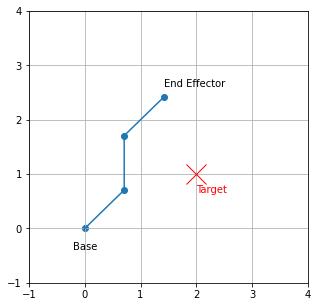

In [10]:
# FK: 3x3 Homogeneous Transformation Matrix

L = [1, 1, 1]
N = len(L)
TH = np.radians([45, 45, -45])

R00 = np.array([[np.cos(TH[0]), -np.sin(TH[0]),    0],
                [np.sin(TH[0]),  np.cos(TH[0]),    0],
                [            0,              0,    1]])

R01 = np.array([[np.cos(TH[1]), -np.sin(TH[1]), L[0]],
                [np.sin(TH[1]),  np.cos(TH[1]),    0],
                [            0,              0,    1]])

R12 = np.array([[np.cos(TH[2]), -np.sin(TH[2]), L[1]],
                [np.sin(TH[2]),  np.cos(TH[2]),    0],
                [            0,              0,    1]])

R23 = np.array([[            1,             0,  L[2]],
                [            0,             1,     0],
                [            0,             0,     1]])

R = [R00, R01, R12, R23]
Rn = np.identity(3)

for i in range(N + 1):
    Rn = Rn @ R[i]
    

P = np.array([[0, 0, 1]])
T00 = R00 @ P.T
T01 = R00 @ R01 @ P.T
T02 = R00 @ R01 @ R12 @ P.T
T03 = R00 @ R01 @ R12 @ R23 @ P.T

X = [T00[0, 0], T01[0, 0], T02[0, 0], T03[0, 0]]
Y = [T00[1, 0], T01[1, 0], T02[1, 0], T03[1, 0]]

Target = np.array([2, 1, 1])
Plot(X, Y)

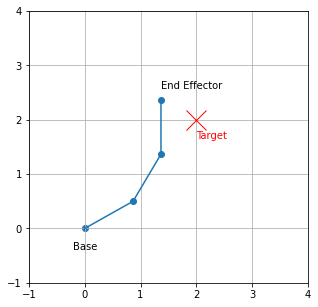

In [29]:
# FK and IK with Jacobian + Homogeneous Transformation Matrix

N = 3                               # the number of links
L  = [0.0] + [1.0] * N              # length of each link
TH = [np.radians(90 / N)] * N + [0] # theta at each joint
Target = np.array([2.0, 2.0, 1.0])  # target coodinates(dummy)

def R(L, TH): # Homogeneous Transformation Matrix for FK
    r = np.array([[np.cos(TH), -np.sin(TH), L],
                  [np.sin(TH),  np.cos(TH), 0],
                  [         0,           0, 1]])
    return r

X = []
Y = []
V = np.identity(3)
for i in range(N + 1):
    V = V @ R(L[i], TH[i])
    X.append(V[0, 2])
    Y.append(V[1, 2])
    
Plot(X, Y)

Error: [-7.64993979e-06  9.12251524e-07]
Loops: 0


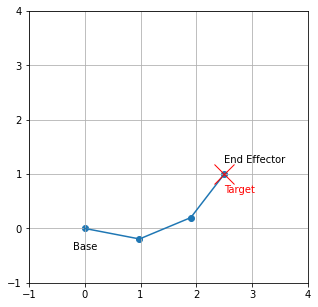

In [32]:
def dR(L, TH): # Derivatives of the Rotation Matrix
    dr = np.array([[-np.sin(TH), -np.cos(TH), L],
                   [ np.cos(TH), -np.sin(TH), 0],
                   [          0,           0, 1]])
    return dr

Target = np.array([2.5, 1, 1], dtype='float64')
LL = sum(L)
TN = norm(Target[:2])
if LL - TN <= 0:
    Target[:2] = Target[:2] * LL / TN
    print('Target overwritten as:', Target[:2])

loops = 0
scaler = 0.5

while True:
    V = np.identity(3)
    for i in range(N + 1):
        V = V @ R(L[i], TH[i])
        
    Err = Target - V[:3, 2] 
    if  norm(Err) < 1e-5:
        print('Error:', Err[:2])
        print('Loops:', loops)
        break
        
    J = np.identity(3)
    for i in range(N + 1):
        J = J @ dR(L[i], TH[i])

    dTheta = inv(J) @ Err.reshape(3, 1) * scaler
    TH[:3] += dTheta.reshape(3,)
        
    loops += 1 
    if loops > 1000:
        print('More than 1000 loops.')
        break   
        
X = []
Y = []
V = np.identity(3)
for i in range(N + 1):
    V = V @ R(L[i], TH[i])
    X.append(V[0, 2])
    Y.append(V[1, 2])
    
Plot(X, Y)

In [ ]:
# 3-Link Arm : Forward Kinematics and Inverse Kinematics with Jacobian Matrix
L1 = 1
L2 = 1
L3 = 1
theta1 = np.radians(45)
theta2 = np.radians(45)
theta3 = np.radians(-45)

Target = [1, 1]
L = [L1, L2, L3]
TH = [theta1, theta2, theta3]
N = len(L)

def FK(L, TH, plot=False):
    x0 = 0
    x1 = x0 + L[0] * np.cos(TH[0])
    x2 = x1 + L[1] * np.cos(TH[0] + TH[1])
    x3 = x2 + L[2] * np.cos(TH[0] + TH[1] + TH[2])
    y0 = 0
    y1 = y0 + L[0] * np.sin(TH[0])
    y2 = y1 + L[1] * np.sin(TH[0] + TH[1])
    y3 = y2 + L[2] * np.sin(TH[0] + TH[1] + TH[2])
    X = [x0, x1, x2, x3]
    Y = [y0, y1, y2, y3]
    if plot:
        return X, Y
    else:
        return np.array([[x3, y3]])

def JMatrix(L, TH):
    L1 = L[0]
    L2 = L[1]
    L3 = L[2]
    S1   = np.sin(TH[0])
    S12  = np.sin(TH[0] + TH[1])
    S123 = np.sin(TH[0] + TH[1] + TH[2])
    C1   = np.cos(TH[0])
    C12  = np.cos(TH[0] + TH[1])
    C123 = np.cos(TH[0] + TH[1] + TH[2])
    J = np.array([[- L1 * S1 - L2 * S12 - L3 * S123, - L2 * S12 - L3 * S123, - L3 * S123], 
                  [  L1 * C1 + L2 * C12 + L3 * C123,   L2 * C12 + L3 * C123, + L3 * C123]])
    return J

def Plot(X, Y):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.axis([-1,N+1,-1,N+1])
    ax.grid()
    ax.plot(X, Y)
    ax.scatter(X, Y)
    ax.plot(Target[0], Target[1], 'ro')
    ax.text(X[0], Y[0]-0.4, 'Base', ha='center')
    ax.text(X[-1], Y[-1]+0.2, 'End Effector', ha='left')
    ax.text(Target[0], Target[1]-0.2, 'Target', ha='left', va='top')
    
X, Y = FK(L, TH, plot=True)
Plot(X, Y)
print('End-effector:  x =',X[-1], ', y =', Y[-1])

In [ ]:
rate = 0.1
loops = 0
if sum(L) - np.linalg.norm(Target) > 0:
    while True:       
        J = JMatrix(L, TH) # Jacobian Matrix
        Jp = J.T.dot(np.linalg.inv(J.dot(J.T))) # J Pseudo Matrix: JT·inv(J·JT)
        
        Err = Target - FK(L, TH)  # error between Target vector and current End-effector vector
        dTheta = Jp @ Err.T    # theta derivartives for the next motion
        TH += dTheta[:, 0] * rate # multiplying some rate to get a smooth transition(but slower)
        loops += 1
        
        ErrNorm = np.linalg.norm(Err)
        if  ErrNorm < 1e-5:
            X, Y = FK(L, TH, plot=True)
            Plot(X, Y)
            print('End-effector:  x =',X[-1], ', y =', Y[-1])
            print('Error(< 1e-5):', ErrNorm)
            print('Loops:', cnt)          
            break       
else:
    print('No reach at all')

In [ ]:
# Interactive Mode: Arm follows Mouse

def motion(event):
    global TH
    mx = event.xdata
    my = event.ydata
    Mouse.set_data(mx, my)
    
    Target = np.array([mx, my])
    TN = np.linalg.norm(Target)
    if sum(L) - TN <= 0:
        Target *= sum(L) / TN
    
    while True:
        J = JMatrix(L, TH)        # Jacobian Matrix
        Jp = J.T.dot(np.linalg.inv(J.dot(J.T))) # J Pseudo Matrix: JT·inv(J·JT)
        Err = Target - FK(L, TH)  # error between Target vector and current End-effector vector
        dTheta = Jp.@ Err.T    # theta derivartives for the next motion
        ErrNorm = np.linalg.norm(Err)
        if  ErrNorm < 0.1:
            break
    
    X, Y = FK(L, TH, plot=True)
    LLine.set_data(X, Y)
    LDot.set_data(X, Y)
    rate = 1
    TH += dTheta[:, 0] * rate
    
    plt.draw()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N+1,-1,N+1], 'equal')
ax.grid()

LLine, = ax.plot([],[], linestyle='-', color='blue', alpha=1)
LDot, = ax.plot([],[], marker='o', color='blue')
Mouse, = ax.plot([],[], marker='x', ms=20, color='red')

plt.connect('motion_notify_event', motion) #'axes_enter_event' 'motion_notify_event'
plt.show()

In [ ]:
N = 5
L = [1] * N
TH = [np.pi / 8] * N
Base = [0, 0]

def nFK(L, TH, plot=False):
    N = len(L)
    X = [Base[0]]
    Y = [Base[1]]
    theta = 0
    for i in range(N):
        theta += TH[i]
        X.append(X[-1] + L[i] * np.cos(theta))
        Y.append(Y[-1] + L[i] * np.sin(theta))
    if plot:
        return X, Y
    else:
        return np.array([[X[-1], Y[-1]]])


def nJMatrix(L, TH):
    N = len(L)
    X = []
    Y = []
    for i in range(N):
        theta = 0
        x = 0
        y = 0
        for j in range(i + 1):
            theta += TH[j]
            x -= L[j] * np.sin(theta)
            y += L[j] * np.cos(theta)
        X.append(x)
        Y.append(y)
    return np.array([X, Y])

X, Y = nFK(L, TH, plot=True)
Plot(X, Y)

In [ ]:
def n_motion(event):
    global TH
    mx = event.xdata
    my = event.ydata
    Mouse.set_data(mx, my)
    
    Target = np.array([mx, my])
    TN = np.linalg.norm(Target)
    if sum(L) - TN <= 0:
        Target *= sum(L) / TN
        
    J = nJMatrix(L, TH)        # Jacobian Matrix
    Jp = J.T.dot(np.linalg.inv(J.dot(J.T))) # J Pseudo Matrix: JT·inv(J·JT)
    Err = Target - nFK(L, TH)  # error between Target vector and current End-effector vector
    dTheta = Jp.dot(Err.T)     # theta derivartives for the next motion
    
    X, Y = nFK(L, TH, plot=True)
    LLine.set_data(X, Y)
    LDot.set_data(X, Y)
    rate = 0.1
    TH += dTheta[:, 0] * rate
    
    ax.draw()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N+1,-1,N+1], 'equal')
ax.grid()

LLine, = ax.plot([],[], linestyle='-', color='blue', alpha=1)
LDot, = ax.plot([],[], marker='o', color='blue')
Mouse, = ax.plot([],[], marker='x', ms=20, color='red')

plt.connect('motion_notify_event', n_motion)
plt.show()

In [ ]:
N = 3
Base = [0, 0]

# L = [1, 1, 1]
# Theta = np.radians([30, 30, 30]) # as degree
L = [1] * N
#Theta = [20] * N
Theta = np.radians(np.random.randint(0, 30, N))

def FK(L, Theta):
    N = len(L)
    X = [Base[0]]
    Y = [Base[1]]
    x = 0
    y = 0
    th = 0
    for i in range(N):
        th += Theta[i]
        x += L[i] * np.cos(th)
        y += L[i] * np.sin(th)
        X.append(x)
        Y.append(y)
    return X, Y

X, Y = FK(L, Theta)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N+1,-1,N+1])
ax.grid()
ax.plot(X, Y)
ax.scatter(X, Y)
ax.text(X[0], Y[0]-0.4, 'Base', ha='center')
ax.text(X[N], Y[N]+0.2, 'End Effector', ha='left')

In [ ]:
L1 = 1
L2 = 1
L3 = 1

th1 = np.radians(90)
th2 = np.radians(90)
th3 = np.radians(90)

P0 = np.array([0, 0, 0])
P1 = P0 + np.array([L1 * np.cos(th1), L1 * np.sin(th1), th1])
P2 = P1 + np.array([L2 * np.cos(th1 + th2), L2 * np.sin(th1 + th2), th2])
P3 = P2 + np.array([L3 * np.cos(th1 + th2 + th3), L2 * np.sin(th1 + th2 + th3), th3])

Q = np.array([P0, P1, P2, P3])

# dxdth1 = -L1 * np.sin(th1) - L2 * np.sin(th1 + th2) - L3 * np.sin(th1 + th2 + th3)
# dxdth2 = -L2 * np.sin(th1 + th2) - L3 * np.sin(th1 + th2 + th3)
# dxdth3 = -L3 * np.sin(th1 + th2 + th3)
# dydth1 =  L1 * np.cos(th1) + L2 * np.cos(th1 + th2) + L3 * np.cos(th1 + th2 + th3)
# dydth2 =  L2 * np.cos(th1 + th2) + L3 * np.cos(th1 + th2 + th3)
# dydth3 =  L3 * np.cos(th1 + th2 + th3)
# dthdth1 = 1
# dthdth2 = 1
# dthdth3 = 1

# J = np.array([[dxdth1,  dxdth2,  dxdth3],
#               [dydth1,  dydth2,  dydth3], 
#               [dthdth1, dthdth2, dthdth3]])

In [ ]:
N = 3
X = []
Y = []
for i in range(N+1):
    X.append(Q[i, 0])
    Y.append(Q[i, 1])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-2,N+1,-2,N+1])
ax.grid()
ax.plot(X, Y)
print(X)